In [1]:
import torch
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from PIL import Image

import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms

In [ ]:
torch.nn.

In [2]:
def show_images(images_tensor:torch.tensor):
    n_dims = images_tensor.dim()
    
    if n_dims in (2,3):
        x_cat = images_tensor

    elif n_dims == 4:
        x_list = [img for img in images_tensor]
        x_cat = torch.cat(x_list,dim=2)
    
    else:
        raise SyntaxError("The dimensions of images_tensor must be between 2 and 4")

    if n_dims != 2:
        if x_cat.shape[0] == 1:
            plt.imshow(x_cat.movedim(0,-1),cmap="gray");
        else:
            plt.imshow(x_cat.movedim(0,-1));
    else:
        plt.imshow(x_cat,cmap="gray");

In [3]:
def show_images_list(images_list:list[torch.Tensor]) -> None:

    images_tensor = torch.concat(images_list,dim=0)

    # return images_tensor
    # show_images(images_tensor.unsqueeze(1))
    show_images(images_tensor)


In [4]:
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)

In [5]:
model = UNet2DModel(
    in_channels=3,  # 3 channels for RGB images
    sample_size=64,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
        ),

).cuda()
model.load_state_dict(torch.load("../Training_diffusion/First_train.pth", weights_only=True))
model.eval()

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

  0%|          | 0/1000 [00:00<?, ?it/s]

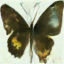

In [6]:
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images

ims[0]

# Bucle de generación

1. Vamos a cargar la imagen que entrará en la red.

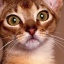

In [7]:
import requests

response = requests.get("https://av9.dev/cat-dataset/cats/cat_9929.png",stream=True).raw
OOD_img_raw = Image.open(response)
OOD_img_raw

2. Transformamos la imagen para cargarlas a la red

In [9]:
image_size = 64

#Prepare images to load to the net

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),  #Data augmentation
        transforms.ToTensor(),              #Convert to Tensor
        transforms.Normalize([0.5],[0.5])   #Map tp -1 to 1
    ]
)

def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


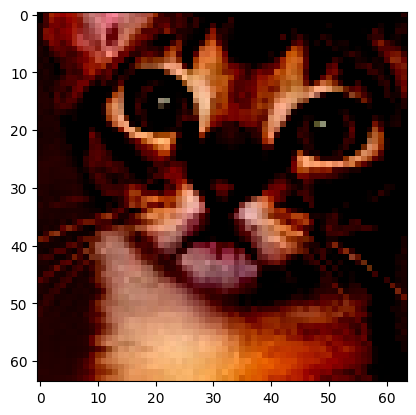

In [10]:
OOD_img = preprocess(OOD_img_raw).cuda()
show_images(OOD_img.cpu())

3. Añadir ruido aleatorio a la imagen

Tamaños del ruido:  torch.Size([3, 64, 64])


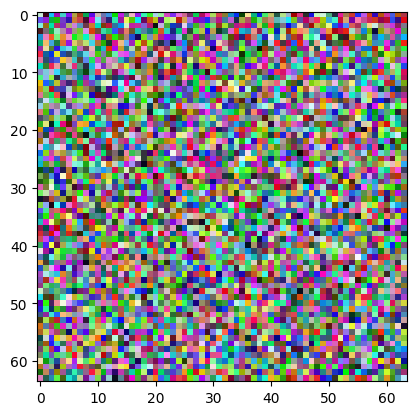

In [11]:
noise = torch.rand_like(OOD_img).cuda()
print("Tamaños del ruido: ",noise.shape)
show_images(noise.cpu())

In [12]:
random_timestep = torch.randint(0,1000,(1,)).cuda()
random_timestep

tensor([382], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39558616..1.3188069].


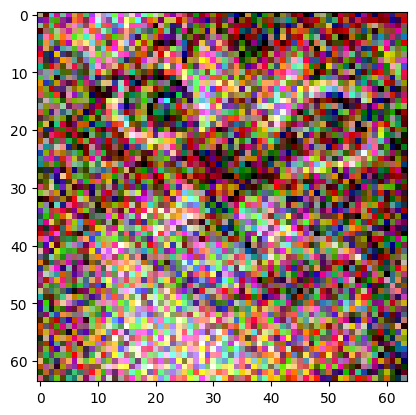

In [13]:
noisy_OOD = scheduler.add_noise(OOD_img,noise,random_timestep)
show_images(noisy_OOD.cpu())

4. Bucle de restauración de la imagen

In [14]:
def DDPM_generation_loop(input_img:torch.Tensor, input_timestep : int):

    if input_img.dim() != 4:
        raise SyntaxError("Error de Dimensiones. El Tensor de entrada dbe tener 4 dimensions, siendo la primera la dimensión de lote")
    
    noisy_x = input_img

    if input_timestep < 0 or input_timestep > 1000:
        raise SyntaxError("El timestep debe estar entre 0 y 1000")
    
    for t in range(input_timestep,-1,-1):

        with torch.inference_mode():
            noise_pred = model(noisy_x, t,return_dict=False)[0]

        scheduler_output = scheduler.step(noise_pred, t, noisy_x)

        noisy_x = scheduler_output.prev_sample
    
    return(scheduler_output.pred_original_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28982168..1.0].


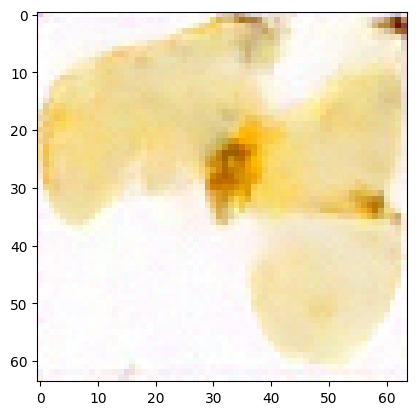

In [15]:
OOD_final = DDPM_generation_loop(noisy_OOD.unsqueeze(0), random_timestep.item())

show_images(OOD_final.cpu())

## Probemos con una imagen del dataset

Repo card metadata block was not found. Setting CardData to empty.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..1.0].


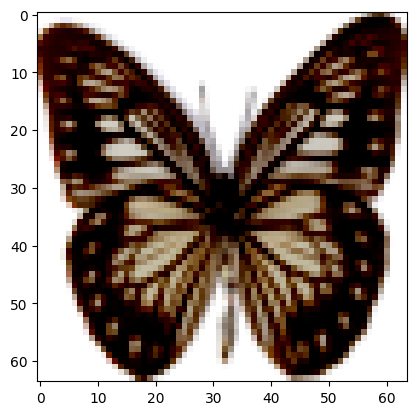

In [16]:
# Download Dataset from hugging-face
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
dataset.set_transform(transform)
IOD_img = dataset[858]["images"].cuda()
show_images(IOD_img.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27857515..1.3220727].


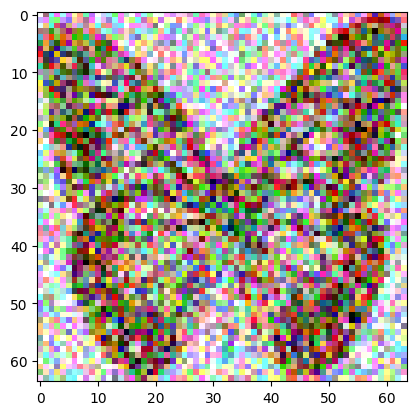

In [17]:
noisy_IOD = scheduler.add_noise(IOD_img,noise, random_timestep)
show_images(noisy_IOD.cpu())

In [18]:
random_timestep

tensor([382], device='cuda:0')

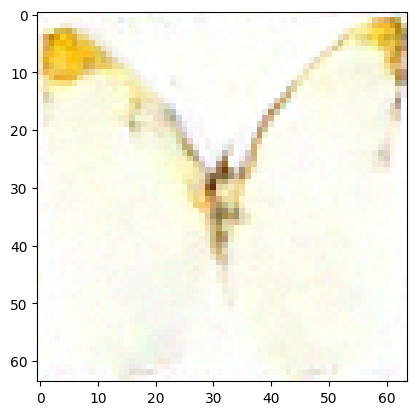

In [19]:
IOD_final = DDPM_generation_loop(noisy_IOD.unsqueeze(0), random_timestep.item())

show_images(IOD_final.cpu())

# Vamos a comparar las imágenes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.3188069].


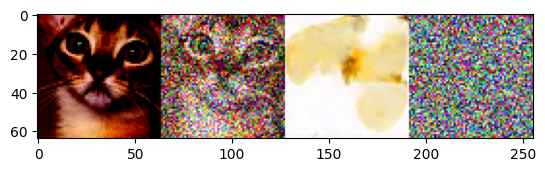

In [20]:
# show_images_list([OOD_img.cpu().detach(),noisy_image.cpu().detach(),noise_prec.squeeze().cpu().detach(),img_step.pred_original_sample.squeeze().cpu().detach()])
show_images_list([OOD_img.unsqueeze(0).cpu().detach(),noisy_OOD.unsqueeze(0).cpu().detach(),OOD_final.cpu().detach(),noise.unsqueeze(0).cpu().detach()])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..1.3220727].


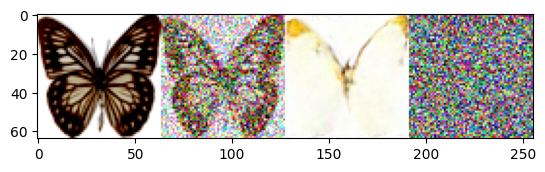

In [21]:
show_images_list([IOD_img.unsqueeze(0).cpu().detach(),noisy_IOD.unsqueeze(0).cpu().detach(),IOD_final.cpu().detach(),noise.unsqueeze(0).cpu().detach()])


# Métricas

Medidas para comprobar y poder detectar muestras OOD.

In [25]:
OOD_MSE = torch.nn.functional.mse_loss(OOD_final.squeeze(),OOD_img) 
OOD_MSE

tensor(1.0271, device='cuda:0')

In [26]:
IOD_MSE = torch.nn.functional.mse_loss(IOD_final.squeeze(),IOD_img)
IOD_MSE

tensor(0.6040, device='cuda:0')

In [27]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze').cuda()

lpips_OOD = lpips(OOD_final,OOD_img.unsqueeze(0))
lpips_OOD

tensor(0.6664, device='cuda:0')

In [28]:
lpips_IOD = lpips(IOD_final,IOD_img.unsqueeze(0))
lpips_IOD

tensor(0.4984, device='cuda:0')